In [10]:
library(tidyverse)
library(dplyr)
library(caret)
library(kernlab)
library(e1071)

In [11]:
data <- read.csv("/home/hasan/Data Set/iris/Iris.csv")
head(data)

Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa
5,5.0,3.6,1.4,0.2,Iris-setosa
6,5.4,3.9,1.7,0.4,Iris-setosa


In [12]:
dim(data)

[1] 150   6

In [13]:
# Selecting necessary columns 
data = data[,2:6]

In [14]:
# Changing columns name
data = data %>%
            rename(
                sepal_length = SepalLengthCm,
                sepal_width = SepalWidthCm,
                petal_length = PetalLengthCm,
                petal_width = PetalWidthCm,
                species = Species
            )

In [15]:
# unique of species column 
levels(data$species)

[1] "Iris-setosa"     "Iris-versicolor" "Iris-virginica"

In [16]:
# unique data in species column 
unique(data$species)

[1] Iris-setosa     Iris-versicolor Iris-virginica 
Levels: Iris-setosa Iris-versicolor Iris-virginica

In [17]:
summary(data)

  sepal_length    sepal_width     petal_length    petal_width   
 Min.   :4.300   Min.   :2.000   Min.   :1.000   Min.   :0.100  
 1st Qu.:5.100   1st Qu.:2.800   1st Qu.:1.600   1st Qu.:0.300  
 Median :5.800   Median :3.000   Median :4.350   Median :1.300  
 Mean   :5.843   Mean   :3.054   Mean   :3.759   Mean   :1.199  
 3rd Qu.:6.400   3rd Qu.:3.300   3rd Qu.:5.100   3rd Qu.:1.800  
 Max.   :7.900   Max.   :4.400   Max.   :6.900   Max.   :2.500  
            species  
 Iris-setosa    :50  
 Iris-versicolor:50  
 Iris-virginica :50  
                     
                     
                     

In [18]:
# Total unique data in species column 
uniqu_count <- group_by(data, data$species) %>%
                    summarize(count=n())
uniqu_count

data$species,count
Iris-setosa,50
Iris-versicolor,50
Iris-virginica,50


In [19]:
# Mean value of every class for every numerical columns 
data %>%
    group_by(species) %>%
    summarize_if(is.numeric, mean) 

species,sepal_length,sepal_width,petal_length,petal_width
Iris-setosa,5.006,3.418,1.464,0.244
Iris-versicolor,5.936,2.770,4.260,1.326
Iris-virginica,6.588,2.974,5.552,2.026


# Some EDA(Exploratory Data Analysis)

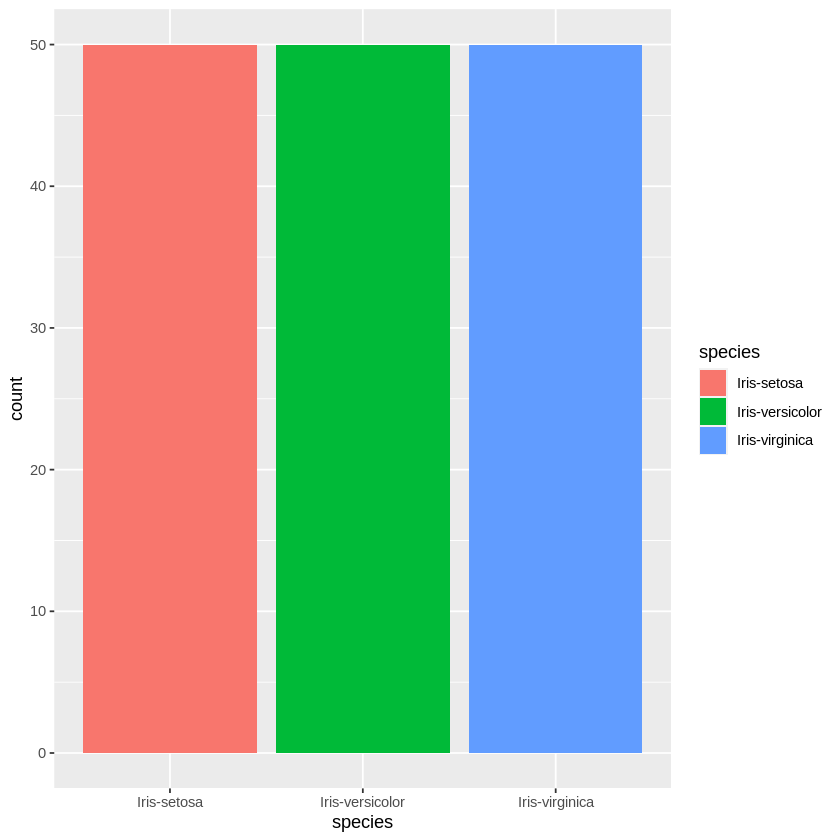

In [20]:
ggplot(data=data) + 
       geom_bar(mapping=aes(x=species, fill=species))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


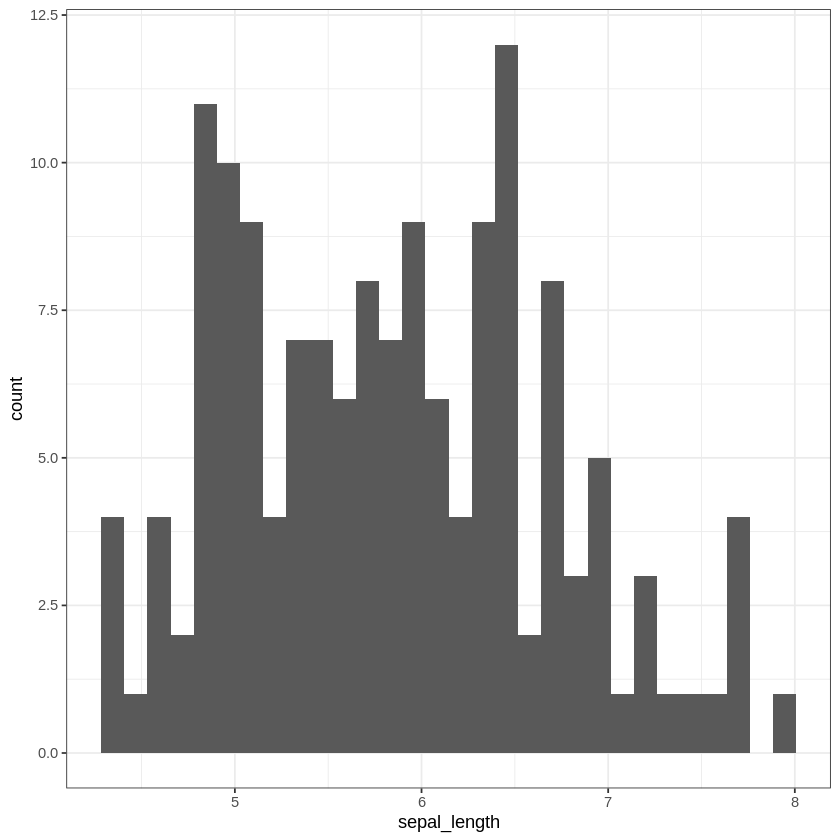

In [21]:
ggplot(data, aes(x=sepal_length)) +
    theme_bw() +
    geom_histogram()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


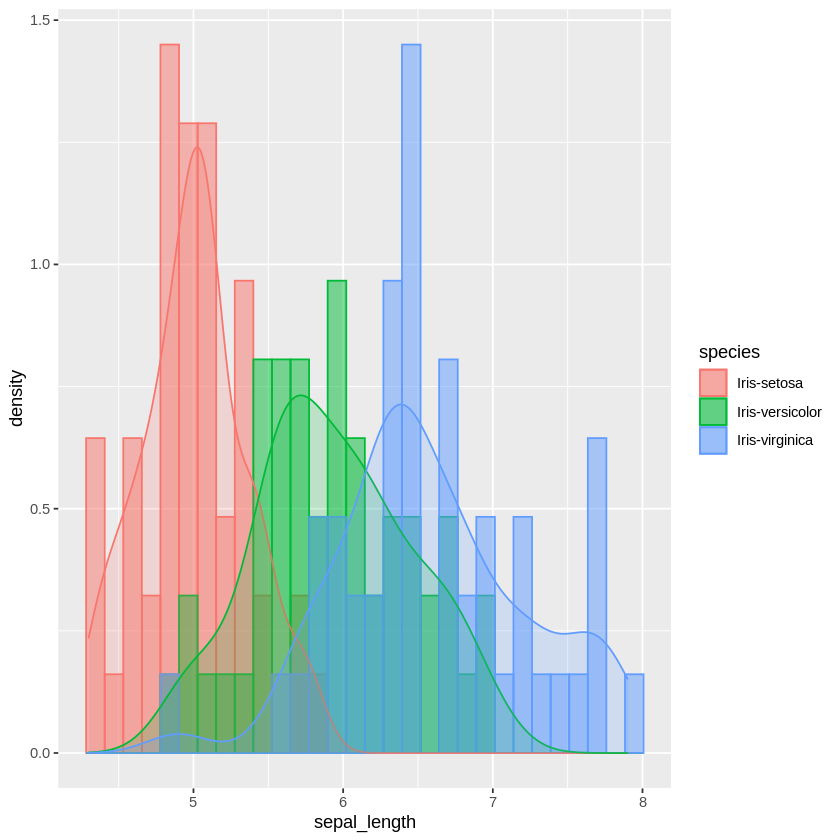

In [22]:
ggplot(data, aes(x=sepal_length, color=species, fill=species)) +
    geom_histogram(aes(y=..density..), alpha=0.5, position='identity') +
    geom_density(alpha=.2)

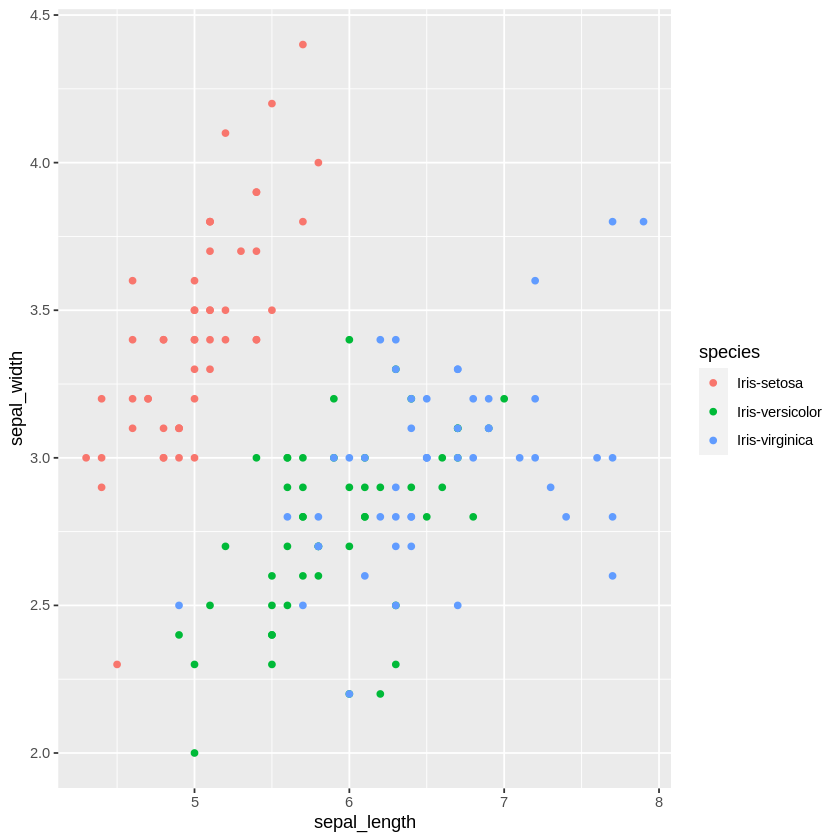

In [23]:
ggplot(data=data) + 
       geom_point(mapping=aes(x=sepal_length, y=sepal_width, color=species))

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


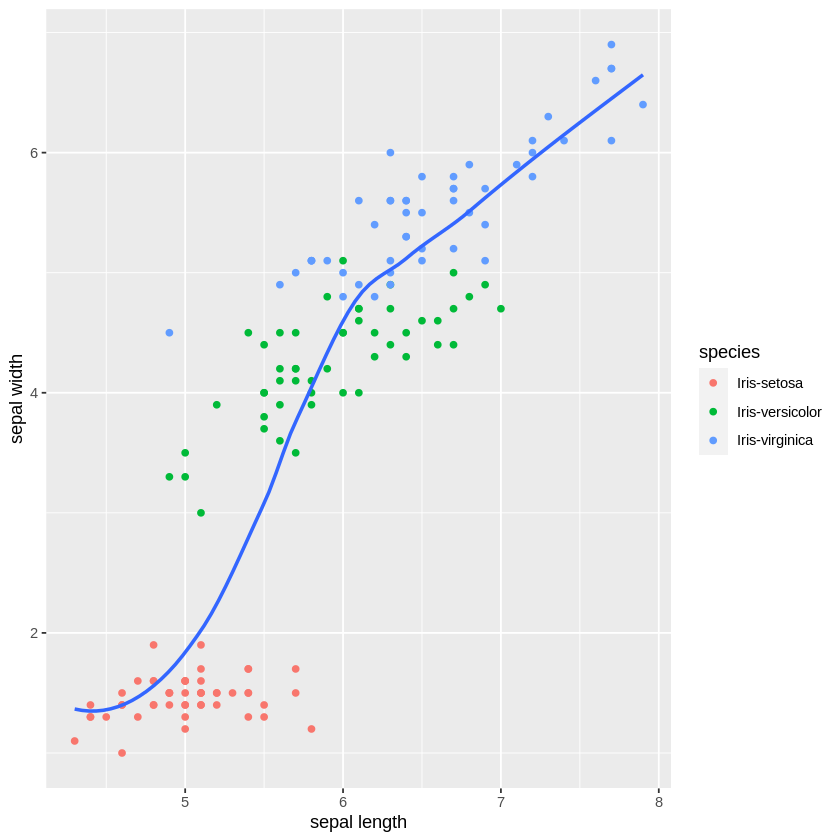

In [24]:
ggplot(data, aes(sepal_length, petal_length)) + 
       geom_point(aes(color=species)) +
       geom_smooth(se=FALSE) +
       labs(
           x = "sepal length",
           y = 'sepal width',
           colour = 'species'
       )

In [25]:
best_in_class <- data %>%
group_by(species) %>%
filter(row_number(desc(petal_length)) == 1)

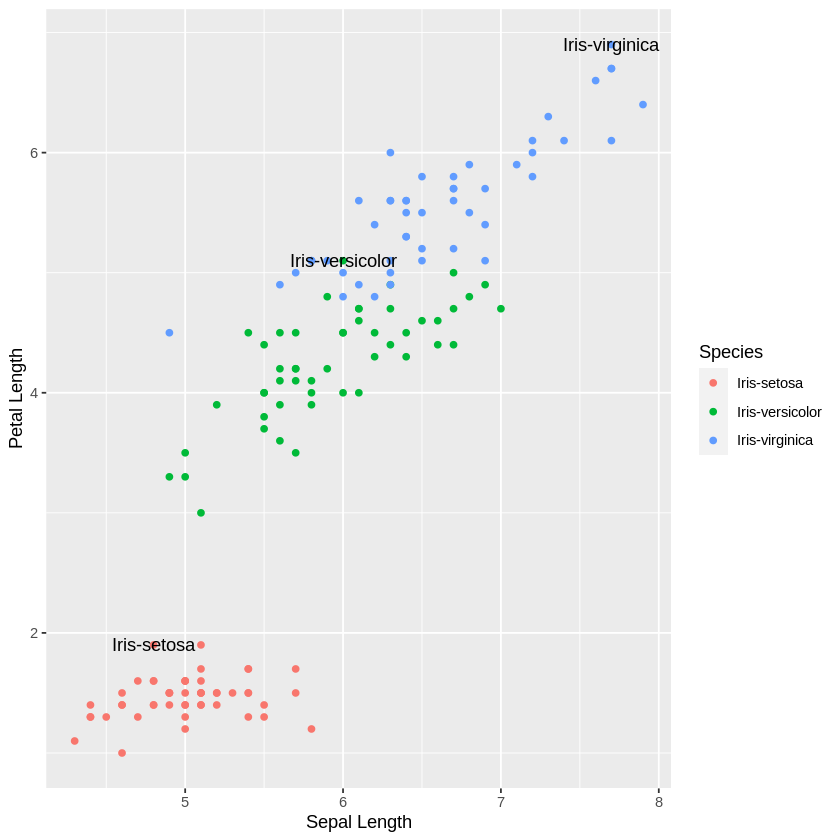

In [26]:
ggplot(data, aes(sepal_length, petal_length)) +
    geom_point(aes(color = species)) +
    geom_text(aes(label = species),data = best_in_class) +
    labs(
         x = 'Sepal Length',
         y = 'Petal Length',
         colour = 'Species'
    )

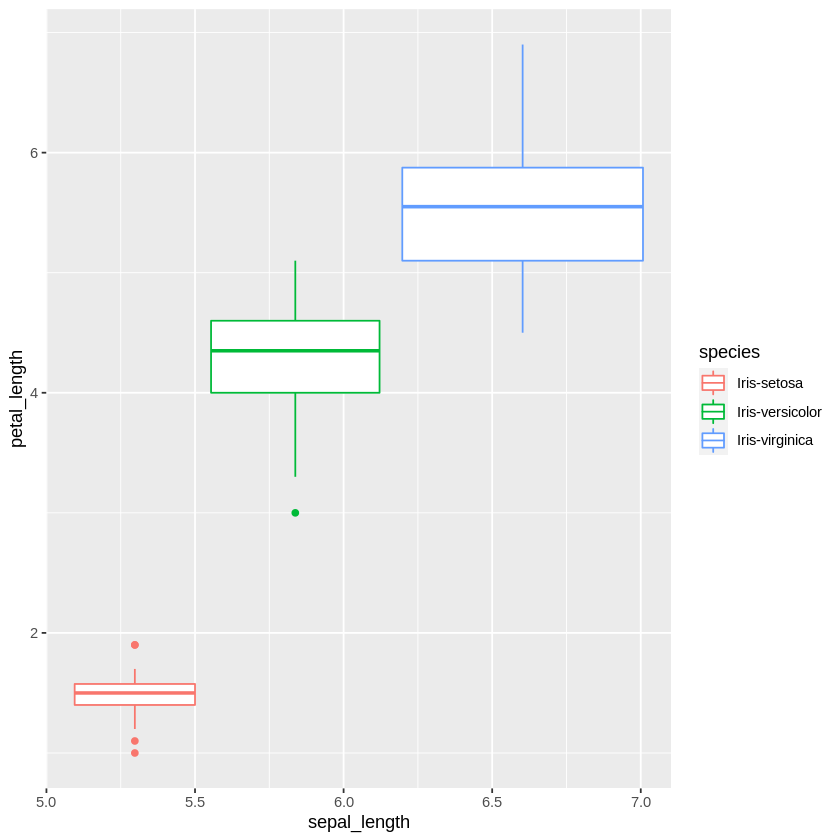

In [27]:
p <- ggplot(data, aes(x=sepal_length, y=petal_length, color=species)) +
    geom_boxplot()
p

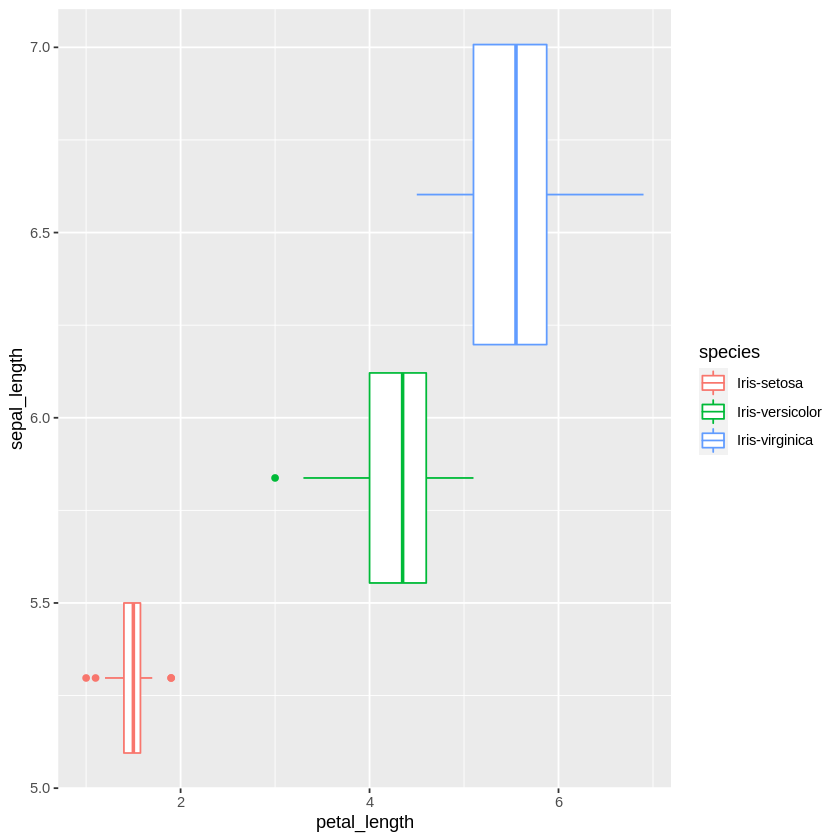

In [28]:
p + coord_flip()

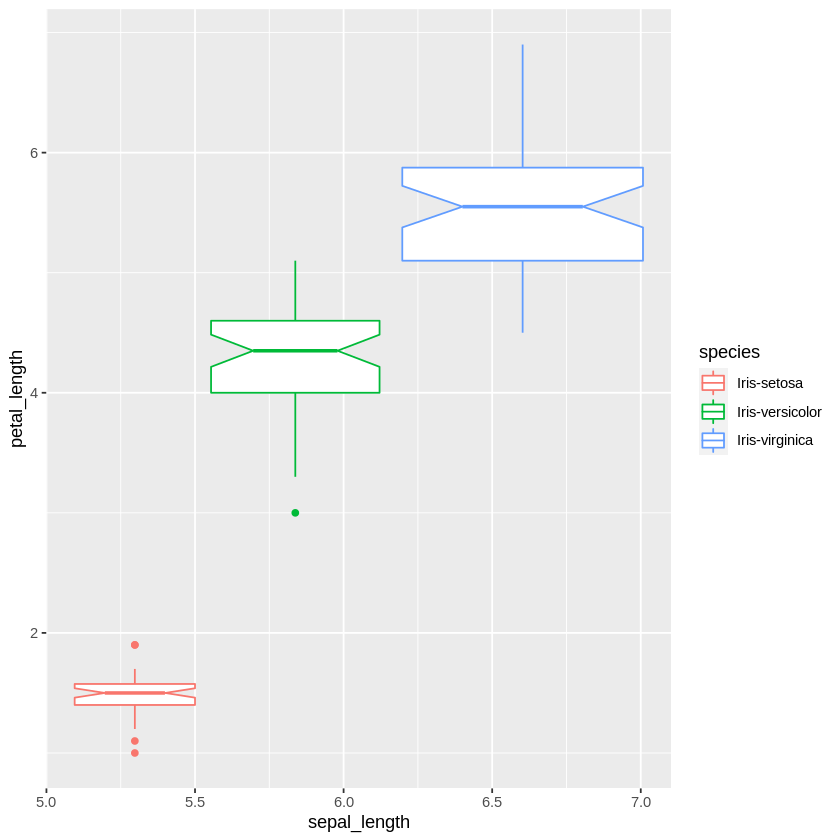

In [29]:
p <- ggplot(data, aes(x=sepal_length, y=petal_length, color=species)) +
    geom_boxplot(notch=TRUE)
p

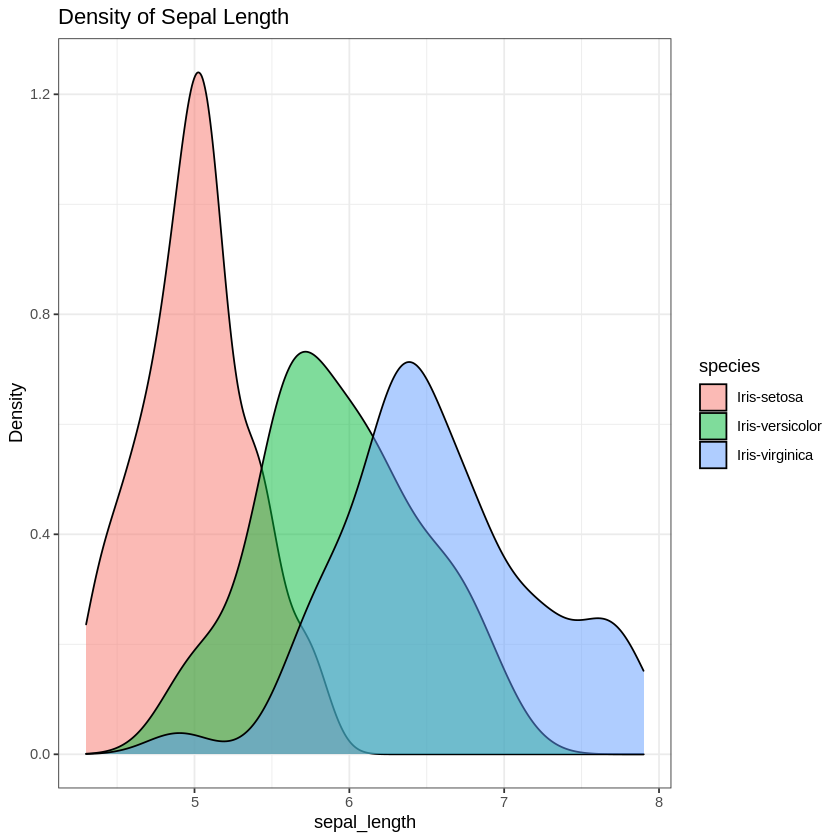

In [30]:
ggplot(data, aes(x=sepal_length, fill=species)) +
    theme_bw() +
    #facet_wrap(species) +
    geom_density(alpha=0.5) +
    labs(y='Density',
         x='sepal_length',
         title='Density of Sepal Length')

# Building Model

In [31]:
head(data)

sepal_length,sepal_width,petal_length,petal_width,species
5.1,3.5,1.4,0.2,Iris-setosa
4.9,3.0,1.4,0.2,Iris-setosa
4.7,3.2,1.3,0.2,Iris-setosa
4.6,3.1,1.5,0.2,Iris-setosa
5.0,3.6,1.4,0.2,Iris-setosa
5.4,3.9,1.7,0.4,Iris-setosa


In [32]:
# Checking null data
sum(is.na(data))

[1] 0

In [33]:
# Dividing dataset into train and test
train_index <- createDataPartition(data$species, p=0.8, list = FALSE)
train_set <- data[train_index,]
test_set <- data[-train_index,]

In [35]:
dim(train_set)
dim(test_set)

[1] 120   5

[1] 30  5

In [85]:
# To achieve reproducible model; set the random seed number
set.seed(100)


# Build model
model <- train(species ~ ., 
               data = train_set,
               method = "svmPoly",
               na.action = na.omit,
               preProcess=c("scale","center"),
               trControl= trainControl(method="none"),
               tuneGrid = data.frame(degree=1,scale=1,C=1)
)


In [86]:
model_train <- predict(model, train_set)
model_test <- predict(model, test_set)


In [87]:
model_train_confusion <- confusionMatrix(model_train, train_set$species)
model_test_confusion <- confusionMatrix(model_test, test_set$species)

In [89]:
model_train_confusion

Confusion Matrix and Statistics

                 Reference
Prediction        Iris-setosa Iris-versicolor Iris-virginica
  Iris-setosa              40               0              0
  Iris-versicolor           0              39              1
  Iris-virginica            0               1             39

Overall Statistics
                                         
               Accuracy : 0.9833         
                 95% CI : (0.9411, 0.998)
    No Information Rate : 0.3333         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.975          
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: Iris-setosa Class: Iris-versicolor
Sensitivity                      1.0000                 0.9750
Specificity                      1.0000                 0.9875
Pos Pred Value                   1.0000                 0.9750
Neg Pred Value         

In [90]:
model_test_confusion

Confusion Matrix and Statistics

                 Reference
Prediction        Iris-setosa Iris-versicolor Iris-virginica
  Iris-setosa              10               0              0
  Iris-versicolor           0               9              0
  Iris-virginica            0               1             10

Overall Statistics
                                          
               Accuracy : 0.9667          
                 95% CI : (0.8278, 0.9992)
    No Information Rate : 0.3333          
    P-Value [Acc > NIR] : 2.963e-13       
                                          
                  Kappa : 0.95            
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: Iris-setosa Class: Iris-versicolor
Sensitivity                      1.0000                 0.9000
Specificity                      1.0000                 1.0000
Pos Pred Value                   1.0000                 1.0000
Neg Pred Value

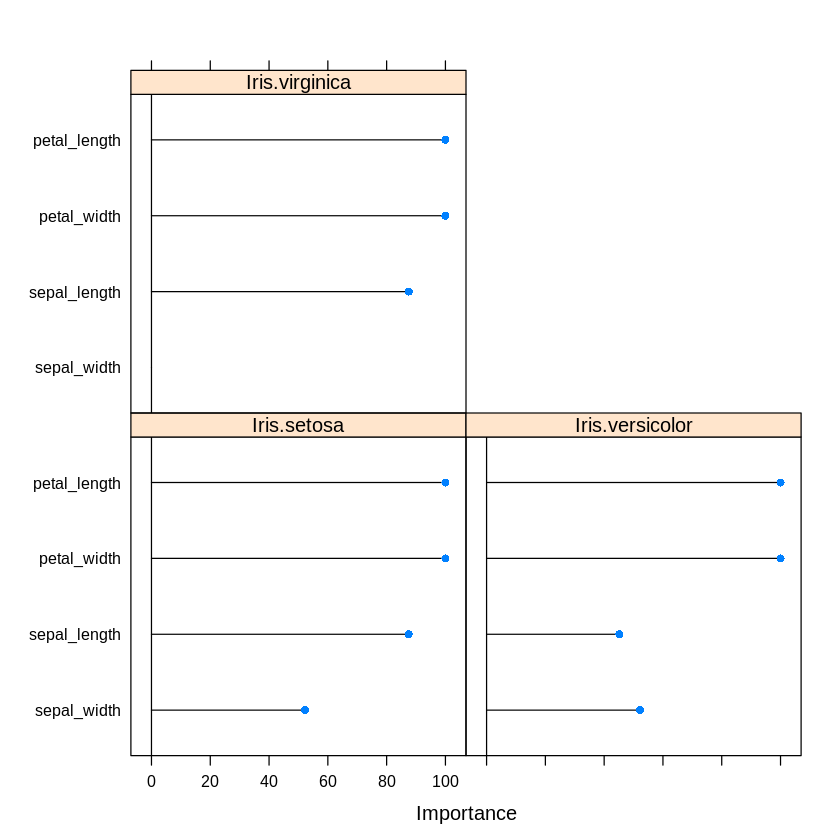

In [93]:
# Feature importance
importance <- varImp(model)
plot(importance)

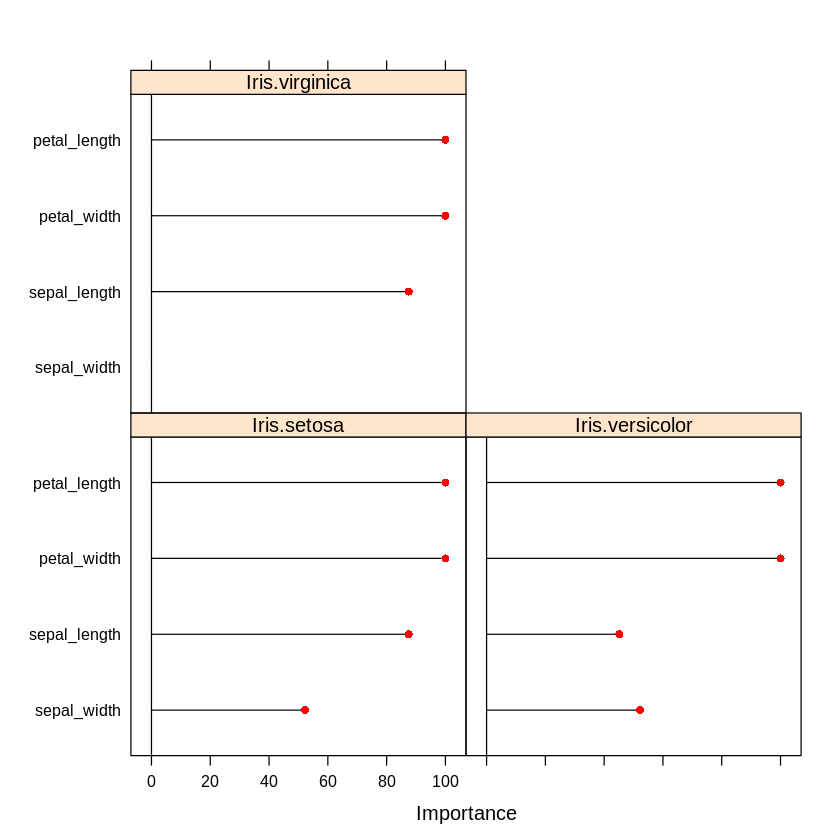

In [94]:
plot(importance, col='red')

# with CV Model

In [98]:
# Build model with CV
model_cv <- train(species ~ ., 
                  data = train_set,
                  method = "svmPoly",
                  na.action = na.omit,
                  preProcess=c("scale","center"),
                  trControl= trainControl(method="cv", number=10),
                  tuneGrid = data.frame(degree=1,scale=1,C=1)
)

In [99]:
model_cv_train <- predict(model_cv, train_set)
model_cv_test <- predict(model_cv, test_set)

In [101]:
model_cv_train_confusion <- confusionMatrix(model_cv_train, train_set$species)
model_cv_test_confusion <- confusionMatrix(model_cv_test, test_set$species)

In [109]:
print(model_cv_train_confusion)

Confusion Matrix and Statistics

                 Reference
Prediction        Iris-setosa Iris-versicolor Iris-virginica
  Iris-setosa              40               0              0
  Iris-versicolor           0              39              1
  Iris-virginica            0               1             39

Overall Statistics
                                         
               Accuracy : 0.9833         
                 95% CI : (0.9411, 0.998)
    No Information Rate : 0.3333         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.975          
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: Iris-setosa Class: Iris-versicolor
Sensitivity                      1.0000                 0.9750
Specificity                      1.0000                 0.9875
Pos Pred Value                   1.0000                 0.9750
Neg Pred Value         

In [103]:
model_cv_test_confusion

Confusion Matrix and Statistics

                 Reference
Prediction        Iris-setosa Iris-versicolor Iris-virginica
  Iris-setosa              10               0              0
  Iris-versicolor           0               9              0
  Iris-virginica            0               1             10

Overall Statistics
                                          
               Accuracy : 0.9667          
                 95% CI : (0.8278, 0.9992)
    No Information Rate : 0.3333          
    P-Value [Acc > NIR] : 2.963e-13       
                                          
                  Kappa : 0.95            
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: Iris-setosa Class: Iris-versicolor
Sensitivity                      1.0000                 0.9000
Specificity                      1.0000                 1.0000
Pos Pred Value                   1.0000                 1.0000
Neg Pred Value

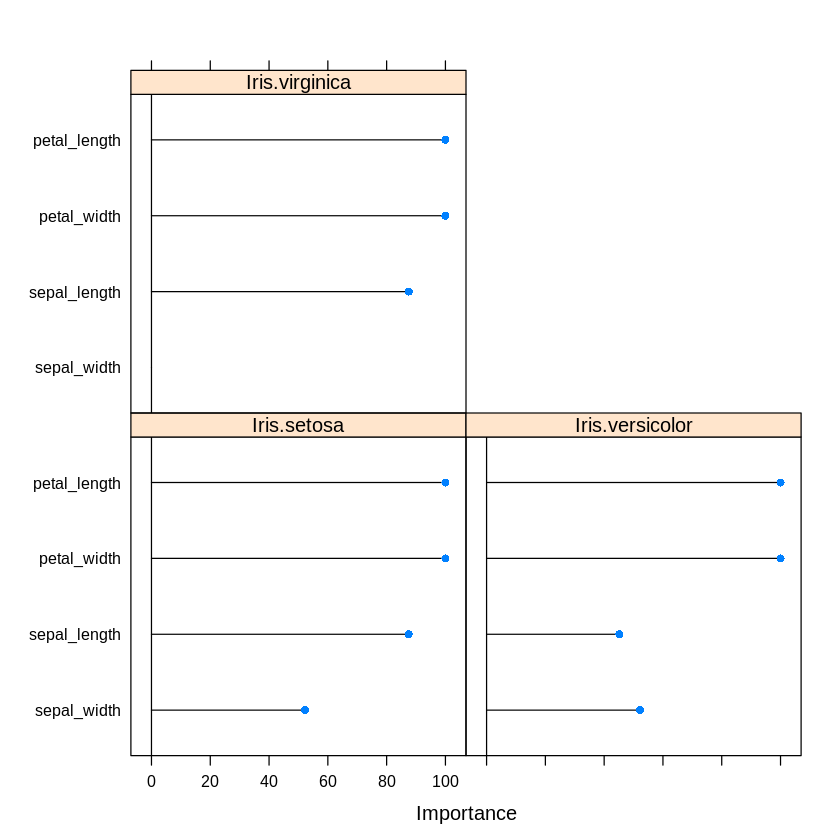

In [104]:
# Feature importance
importance <- varImp(model_cv)
plot(importance)

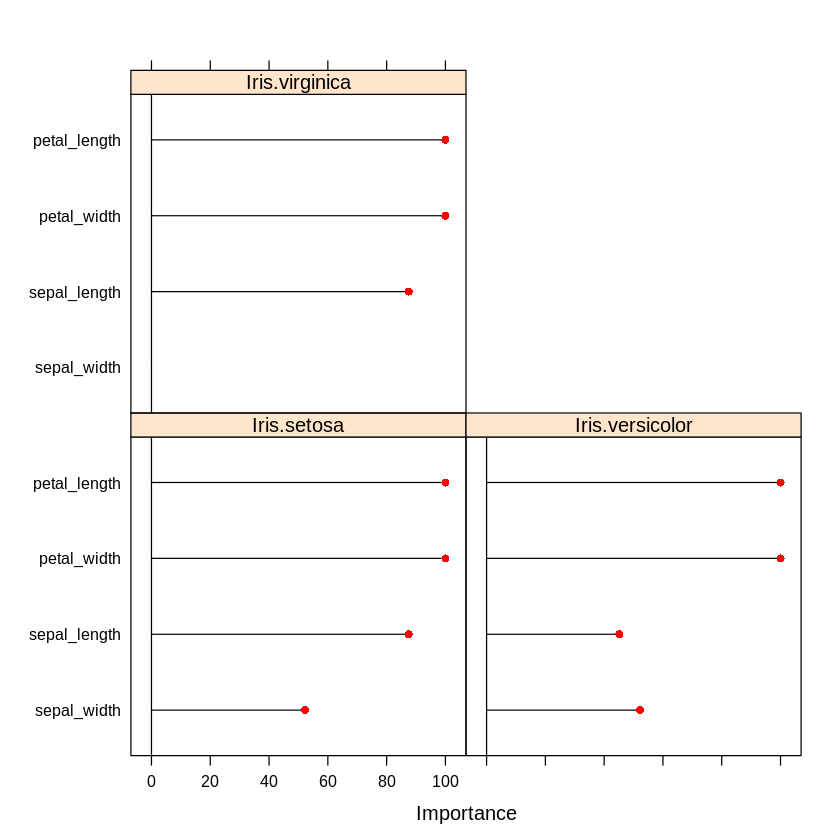

In [108]:
plot(importance, col='red')